In [28]:
import pandas as pd
import numpy as np
import re
from sqlalchemy import create_engine

# ------------------------
# TiDB Cloud credentials - SECURELY STORE YOUR CREDENTIALS
# For demonstration purposes, I will keep them here, but you should move them.
# ------------------------
host = "gateway01.ap-southeast-1.prod.aws.tidbcloud.com"
port = 4000
user = "sJS9A4ifsRxCyhp.root"
password = "BZOhl53om6ZM6iOO"
database = "imdb2024"

# ------------------------
# Create SQLAlchemy engine for TiDB (MySQL)
# This is the single, recommended way to connect
# ------------------------
engine = create_engine(
    f"mysql+pymysql://{user}:{password}@{host}:{port}/{database}",
    connect_args={"ssl": {"ssl": {}}}
)

# ------------------------
# Helper functions (as is from your code)
# ------------------------
def parse_votes(v):
    if pd.isna(v):
        return np.nan
    s = str(v).strip().replace(",", "").replace("(", "").replace(")", "")
    if s.endswith(("K", "k")):
        try:
            return int(float(s[:-1]) * 1_000)
        except:
            return np.nan
    if s.endswith(("M", "m")):
        try:
            return int(float(s[:-1]) * 1_000_000)
        except:
            return np.nan
    try:
        return int(float(s))
    except:
        return np.nan

def parse_duration_to_minutes(s):
    if pd.isna(s):
        return np.nan
    if isinstance(s, (int, float)):
        return float(s)
    text = str(s).lower()
    h = re.search(r"(\d+)\s*h", text)
    m = re.search(r"(\d+)\s*m", text)
    total = 0
    if h: total += int(h.group(1)) * 60
    if m: total += int(m.group(1))
    if total > 0: return float(total)
    m2 = re.search(r"(\d+)\s*min", text)
    if m2: return float(m2.group(1))
    try:
        return float(text)
    except:
        return np.nan

def clean_columns(df):
    rename_map = {
        "Movie Name": "title", "Movie_Name": "title", "movie_name": "title",
        "Genre": "genre", "genre_name": "genre",
        "Ratings": "rating", "Rating": "rating",
        "Voting Counts": "votes", "Votes": "votes",
        "Duration": "duration_raw", "duration": "duration_raw",
        "Duration (min)": "duration_min", "Duration_min": "duration_min",
        "Movie": "title"
    }
    df = df.rename(columns=rename_map)
    for c in ["title", "genre", "rating", "votes", "duration_raw", "duration_min"]:
        if c not in df.columns:
            df[c] = np.nan
    df["rating"] = pd.to_numeric(df["rating"], errors="coerce")
    df["votes"] = df["votes"].apply(parse_votes)
    if df["duration_min"].isna().all():
        df["duration_min"] = df["duration_raw"].apply(parse_duration_to_minutes)
    else:
        df["duration_min"] = df["duration_min"].apply(parse_duration_to_minutes)
    df["genre"] = df["genre"].fillna("").astype(str).str.strip()
    df["genre_primary"] = df["genre"].apply(
        lambda g: g.split(",")[0].strip().title() if isinstance(g, str) else g
    )
    df = df.dropna(subset=["title"]).copy()
    df["title"] = df["title"].astype(str).str.replace(r"^\d+\.\s*", "", regex=True).str.strip()
    df = df.reset_index(drop=True)
    df["duration_hrs"] = df["duration_min"] / 60.0
    return df

# ------------------------
# Load, clean, and upload data to TiDB Cloud
# This section consolidates the data processing
# ------------------------
df_csv = pd.read_csv("data/all_movies.csv")
df_cleaned = clean_columns(df_csv)
df_deduplicated = df_cleaned.drop_duplicates(subset=["title"], keep="first")
df_deduplicated.to_sql("movies", engine, if_exists="replace", index=False)
print(f"Data uploaded successfully to TiDB Cloud! Total rows: {len(df_deduplicated)}")



Data uploaded successfully to TiDB Cloud! Total rows: 174


In [18]:
import pandas as pd
import numpy as np
import re
from sqlalchemy import create_engine

# ------------------------
# TiDB Cloud credentials
# ------------------------
host = "gateway01.ap-southeast-1.prod.aws.tidbcloud.com"
port = 4000
user = "sJS9A4ifsRxCyhp.root"
password = "BZOhl53om6ZM6iOO"
database = "imdb2024"

# ------------------------
# Helper functions
# ------------------------
def parse_votes(v):
    if pd.isna(v):
        return np.nan
    s = str(v).strip().replace(",", "").replace("(", "").replace(")", "")
    if s.endswith(("K", "k")):
        try:
            return int(float(s[:-1]) * 1_000)
        except:
            return np.nan
    if s.endswith(("M", "m")):
        try:
            return int(float(s[:-1]) * 1_000_000)
        except:
            return np.nan
    try:
        return int(float(s))
    except:
        return np.nan

def parse_duration_to_minutes(s):
    if pd.isna(s):
        return np.nan
    if isinstance(s, (int, float)):
        return float(s)
    text = str(s).lower()
    h = re.search(r"(\d+)\s*h", text)
    m = re.search(r"(\d+)\s*m", text)
    total = 0
    if h: total += int(h.group(1)) * 60
    if m: total += int(m.group(1))
    if total > 0: return float(total)
    m2 = re.search(r"(\d+)\s*min", text)
    if m2: return float(m2.group(1))
    try:
        return float(text)
    except:
        return np.nan

def clean_columns(df):
    # rename to canonical names
    rename_map = {
        "Movie Name": "title", "Movie_Name": "title", "movie_name": "title",
        "Genre": "genre", "genre_name": "genre",
        "Ratings": "rating", "Rating": "rating",
        "Voting Counts": "votes", "Votes": "votes",
        "Duration": "duration_raw", "duration": "duration_raw",
        "Duration (min)": "duration_min", "Duration_min": "duration_min",
        "Movie": "title"
    }
    df = df.rename(columns=rename_map)

    # ensure required cols exist
    for c in ["title", "genre", "rating", "votes", "duration_raw", "duration_min"]:
        if c not in df.columns:
            df[c] = np.nan

    # parse numerics
    df["rating"] = pd.to_numeric(df["rating"], errors="coerce")
    df["votes"] = df["votes"].apply(parse_votes)

    # parse duration
    if df["duration_min"].isna().all():
        df["duration_min"] = df["duration_raw"].apply(parse_duration_to_minutes)
    else:
        df["duration_min"] = df["duration_min"].apply(parse_duration_to_minutes)

    # genre cleanup
    df["genre"] = df["genre"].fillna("").astype(str).str.strip()
    df["genre_primary"] = df["genre"].apply(
        lambda g: g.split(",")[0].strip().title() if isinstance(g, str) else g
    )

    # title cleanup
    df = df.dropna(subset=["title"]).copy()
    df["title"] = df["title"].astype(str).str.replace(r"^\d+\.\s*", "", regex=True).str.strip()

    # reset index
    df = df.reset_index(drop=True)

    # derived column
    df["duration_hrs"] = df["duration_min"] / 60.0

    return df

# ------------------------
# Load CSV
# ------------------------
df = pd.read_csv("data/all_movies.csv")

# ------------------------
# Clean data
# ------------------------
df = clean_columns(df)

# ------------------------
# Remove duplicate titles
# ------------------------
before = len(df)
df = df.drop_duplicates(subset=["title"], keep="first")
after = len(df)
print(f"Rows before removing duplicates: {before}")
print(f"Rows after removing duplicates: {after}")

# ------------------------
# Upload to TiDB Cloud securely
# ------------------------
engine = create_engine(
    f"mysql+pymysql://{user}:{password}@{host}:{port}/{database}",
    connect_args={"ssl": {"ssl": {}}}  # ensures secure transport
)

# Write table (replace if exists)
df.to_sql("movies", engine, if_exists="replace", index=False)
print(f"Data uploaded successfully to TiDB Cloud! Total rows: {len(df)}")


Rows before removing duplicates: 243
Rows after removing duplicates: 174
Data uploaded successfully to TiDB Cloud! Total rows: 174


In [ ]:
#Poorly rated movies
query_low_rated = "SELECT title, genre, rating, votes FROM movies WHERE rating < 5 ORDER BY rating ASC;"
df_low_rated = pd.read_sql(query_low_rated, con=engine)
print("\nPoorly-rated movies (rating < 5):")
print(df_low_rated.to_string())



Poorly-rated movies (rating < 5):
                       title    genre  rating   votes
0       Ask Me What You Want  Romance     3.9    1500
1                 Madame Web   Action     4.1  106000
2                 Emmanuelle  Romance     4.1    2100
3   Hellboy: The Crooked Man   Horror     4.5   15000
4                Borderlands   Action     4.7   53000
5                   The Crow   Action     4.7   38000
6                 Night Swim   Horror     4.7   29000
7             River of Blood   Action     4.8    2500
8        Mother of the Bride  Romance     4.8   17000
9                        Y2K   Horror     4.8   17000
10                     Tarot   Horror     4.8   34000


In [ ]:
#Top 10 highest rated movies
query_top_rated = "SELECT title, genre, rating, votes FROM movies ORDER BY rating DESC LIMIT 10;"
df_top_rated = pd.read_sql(query_top_rated, con=engine)
print("\nTop 10 highest-rated movies:")
print(df_top_rated.to_string())



Top 10 highest-rated movies:
                       title    genre  rating   votes
0         Mahavatar Narsimha   Action     9.1   33000
1             Dune: Part Two   Action     8.5  661000
2                   Maharaja   Action     8.4   73000
3               Young Hearts  Romance     7.9    6600
4           Transformers One   Action     7.6   58000
5  The Count of Monte-Cristo   Action     7.6   40000
6       Bob Trevino Likes It   Comedy     7.5    4100
7    Furiosa: A Mad Max Saga   Action     7.5  299000
8       Deadpool & Wolverine   Action     7.5  524000
9               Inside Out 2   Comedy     7.5  230000


In [22]:
# Top 10 most voted movies
print("Top 10 most voted movies:")
top_voted_movies = df.sort_values(by='votes', ascending=False).head(10)
print(top_voted_movies[['title', 'votes', 'rating']].to_string())

Top 10 most voted movies:
                       title   votes  rating
3             Dune: Part Two  661000     8.5
7       Deadpool & Wolverine  524000     7.5
195            The Substance  335000     7.2
11   Furiosa: A Mad Max Saga  299000     7.5
4               Gladiator II  271000     6.5
100           Alien: Romulus  264000     7.1
16                 Civil War  250000     7.0
17              The Fall Guy  234000     6.8
74              Inside Out 2  230000     7.5
196                Nosferatu  229000     7.2


In [23]:
# Average rating by genre
print("\nAverage rating by genre:")
average_rating_by_genre = df.groupby('genre_primary')['rating'].mean().sort_values(ascending=False)
print(average_rating_by_genre.to_string())




Average rating by genre:
genre_primary
Comedy      6.433333
Action      6.340000
Thriller    6.311538
Romance     6.228947
Horror      5.796296


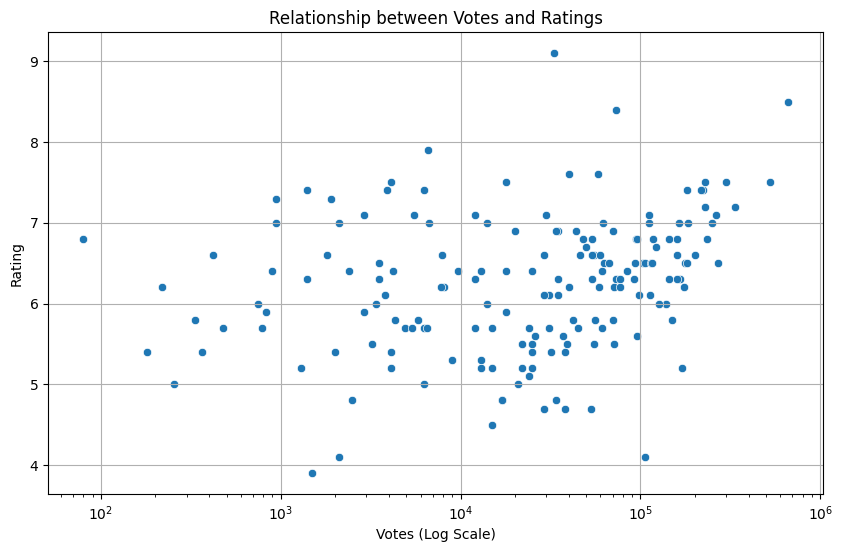

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# #Votes vs Ratings comparison (scatter analysis)
plt.figure(figsize=(10, 6))
# Handle potential log scale issues with votes
df['votes_log'] = df['votes'].replace(0, 1) # replace 0 votes with 1 to avoid log error
sns.scatterplot(x='votes_log', y='rating', data=df)
plt.title('Relationship between Votes and Ratings')
plt.xlabel('Votes (Log Scale)')
plt.ylabel('Rating')
plt.xscale('log')
plt.grid(True)
plt.show()

In [27]:
import pandas as pd
from sqlalchemy import create_engine

# --- TiDB Cloud connection ---
# Replace with your actual credentials for a secure connection.
host = "gateway01.ap-southeast-1.prod.aws.tidbcloud.com"
port = 4000
user = "sJS9A4ifsRxCyhp.root"
password = "BZOhl53om6ZM6iOO"
database = "imdb2024"

# Create SQLAlchemy engine for TiDB (MySQL)
engine = create_engine(
    f"mysql+pymysql://{user}:{password}@{host}:{port}/{database}",
    connect_args={"ssl": {"ssl": {}}}
)

# Load the movies table into a DataFrame
df = pd.read_sql("SELECT * FROM movies", con=engine)

# Find and print the movie with the minimum duration
min_duration_row = df.loc[df['duration_min'].idxmin()]
print("--- Movie with Minimum Duration ---")
print(f"Title: {min_duration_row['title']}")
print(f"Duration: {min_duration_row['duration_min']} minutes")

# Find and print the movie with the maximum duration
max_duration_row = df.loc[df['duration_min'].idxmax()]
print("\n--- Movie with Maximum Duration ---")
print(f"Title: {max_duration_row['title']}")
print(f"Duration: {max_duration_row['duration_min']} minutes")

--- Movie with Minimum Duration ---
Title: Spermageddon
Duration: 80.0 minutes

--- Movie with Maximum Duration ---
Title: The Count of Monte-Cristo
Duration: 178.0 minutes


In [12]:
import pandas as pd
import numpy as np
import re
from sqlalchemy import create_engine

# ---------- Your cleaning functions ----------
def parse_votes(v):
    if pd.isna(v):
        return np.nan
    s = str(v).strip().replace(",", "")
    s = s.replace("(", "").replace(")", "")
    if s.endswith(("K","k")):
        try: return int(float(s[:-1]) * 1_000)
        except: return np.nan
    if s.endswith(("M","m")):
        try: return int(float(s[:-1]) * 1_000_000)
        except: return np.nan
    try:
        return int(float(s))
    except:
        return np.nan

def parse_duration_to_minutes(s):
    if pd.isna(s): return np.nan
    if isinstance(s,(int,float)): return float(s)
    text = str(s).lower()
    h = re.search(r"(\d+)\s*h", text)
    m = re.search(r"(\d+)\s*m", text)
    total = 0
    if h: total += int(h.group(1)) * 60
    if m: total += int(m.group(1))
    if total > 0: return float(total)
    m2 = re.search(r"(\d+)\s*min", text)
    if m2: return float(m2.group(1))
    try: return float(text)
    except: return np.nan

def clean_columns(df):
    rename_map = {
        "Movie Name": "title", "Movie_Name": "title", "movie_name": "title",
        "Genre": "genre", "genre_name": "genre",
        "Ratings": "rating", "Rating": "rating",
        "Voting Counts": "votes", "Votes": "votes",
        "Duration": "duration_raw", "duration": "duration_raw",
        "Duration (min)": "duration_min", "Duration_min": "duration_min",
        "Movie": "title"
    }
    df = df.rename(columns=rename_map)

    # ensure required cols exist
    for c in ["title","genre","rating","votes","duration_raw","duration_min"]:
        if c not in df.columns:
            df[c] = np.nan

    # parse numerics
    df["rating"] = pd.to_numeric(df["rating"], errors="coerce")
    df["votes"]  = df["votes"].apply(parse_votes)
    if df["duration_min"].isna().all():
        df["duration_min"] = df["duration_raw"].apply(parse_duration_to_minutes)
    else:
        df["duration_min"] = df["duration_min"].apply(parse_duration_to_minutes)

    # genre cleanup
    df["genre"] = df["genre"].fillna("").astype(str).str.strip()
    df["genre_primary"] = df["genre"].apply(lambda g: g.split(",")[0].strip().title() if isinstance(g,str) else g)

    # title cleanup
    df = df.dropna(subset=["title"]).copy()
    df["title"] = df["title"].astype(str).str.replace(r"^\d+\.\s*", "", regex=True).str.strip()

    # derived
    df["duration_hrs"] = df["duration_min"] / 60.0
    return df

# ---------- Load & clean ----------
df = pd.read_csv("data/all_movies.csv")
df = clean_columns(df)

# ---------- TiDB Cloud connection ----------
host = "gateway01.ap-southeast-1.prod.aws.tidbcloud.com"
port = 4000
user = "sJS9A4ifsRxCyhp.root"
password = "BZOhl53om6ZM6iOO"
database = "imdb2024"

engine = create_engine(
    f"mysql+mysqlconnector://{user}:{password}@{host}:{port}/{database}"
)

# ---------- Upload cleaned DataFrame ----------
df.to_sql("movies", engine, if_exists="replace", index=False)

print("Movies table updated in TiDB Cloud with duration_min and duration_hrs!")


Movies table updated in TiDB Cloud with duration_min and duration_hrs!
